In [2]:
import os
from pathlib import Path

import pandas as pd
import polars as pl
from matplotlib import pyplot as plt
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from torch import argmax, concat, set_float32_matmul_precision, stack
from torch.utils.data import DataLoader

from mirror.dataloaders.loader import DataModule
from mirror.encoders import TableEncoder, XYDataset, YZDataset, ZDataset
from mirror.encoders.maps import rename
from mirror.models.cvae import CVAE
from mirror.models.cvae_components import (
    CVAEDecoderBlock,
    CVAEEncoderBlock,
    LabelsEncoderBlock,
)

In [5]:
LOGS = Path("./lightning_logs/j6ntwzxy/checkpoints/epoch=0-step=473.ckpt")

In [4]:
census = pl.read_csv("data/census.csv")
census = census.rename(rename)

# drop resident_id_m column
# census = census.drop("pid")
# print(len(census))

# uniques = census.unique()
# p = len(uniques) / len(census)
# print(f"Probability of unique person = {p:.3}")

census.describe()

statistic,pid,social,country_of_birth,employment_status,ethnicity,health,household_type,hours_worked,full_time_student,industry,inner/outer_london,marital_status,occupaion,region,religion,residence_type,age_group,sex,residency_type
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,str,f64,f64,f64,f64,f64
"""count""","""604351""",604351.0,604351.0,604351.0,604351.0,604351.0,604351.0,604351.0,604351.0,604351.0,"""604351""",604351.0,604351.0,"""604351""",604351.0,604351.0,604351.0,604351.0,604351.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0
"""mean""",null,0.178228,1.063016,1.033194,3.497759,1.647728,2.218036,-3.070486,1.264133,2.121696,null,0.153633,1.086539,null,2.323451,1.018094,4.013229,1.489475,1.016006
"""std""",null,4.390827,1.048737,4.964835,1.565592,1.379937,1.718835,5.364332,2.233842,6.579392,null,4.008883,6.134046,null,2.434336,0.133291,2.128897,0.49989,0.142094
"""min""","""PTS000000000001""",-8.0,-8.0,-8.0,-8.0,-8.0,-8.0,-8.0,-8.0,-8.0,"""-8""",-8.0,-8.0,"""E12000001""",-8.0,1.0,1.0,1.0,1.0
"""25%""",null,1.0,1.0,1.0,4.0,1.0,2.0,-8.0,1.0,-8.0,null,1.0,-8.0,null,1.0,1.0,2.0,1.0,1.0
"""50%""",null,2.0,1.0,1.0,4.0,2.0,2.0,-8.0,2.0,5.0,null,1.0,3.0,null,2.0,1.0,4.0,1.0,1.0
"""75%""",null,3.0,1.0,5.0,4.0,2.0,3.0,3.0,2.0,8.0,null,2.0,6.0,null,2.0,1.0,6.0,2.0,1.0
"""max""","""PTS000000604351""",4.0,2.0,9.0,5.0,5.0,5.0,4.0,2.0,9.0,"""E13000002""",5.0,9.0,"""W92000004""",9.0,2.0,7.0,2.0,3.0


In [19]:
logger = WandbLogger(project="test", dir="logs")
trainer = Trainer(logger=logger)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [20]:
trainer.log_dir

'.'

In [ ]:
n = len(xy_dataset)
z_loader = ZDataset(n, latent_size=latent)
yz_loader = YZDataset(z_loader, y_dataset)
gen_loader = DataLoader(
    yz_loader, batch_size=512, num_workers=4, persistent_workers=True
)

ys, xs, zs = zip(*trainer.predict(dataloaders=gen_loader))
ys = concat(ys)
xs = concat([stack([argmax(x, dim=1) for x in xb], dim=-1) for xb in xs], dim=0)
zs = concat(zs)

/home/fred/Projects/mirror/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:149: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /home/fred/Projects/mirror/demo_logs/checkpoints/epoch=0-step=945-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/fred/Projects/mirror/demo_logs/checkpoints/epoch=0-step=945-v14.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

LabelsEncoderBlock device: cuda:0
Input tensor is on device: cuda:0
Embedder device: cuda:0
xs <class 'list'> is on device ?
xs0 <class 'torch.Tensor'> is on device: cuda:0
xs1 <class 'torch.Tensor'> is on device: cuda:0
xs2 <class 'torch.Tensor'> is on device: cuda:0
tensor([1., 3., 2.], device='cuda:0')
<class 'torch.Tensor'>
MADE IT
LabelsEncoderBlock device: cuda:0
Input tensor is on device: cuda:0
Embedder device: cuda:0
xs <class 'list'> is on device ?
xs0 <class 'torch.Tensor'> is on device: cuda:0
xs1 <class 'torch.Tensor'> is on device: cuda:0
xs2 <class 'torch.Tensor'> is on device: cuda:0
tensor([0., 4., 4.], device='cuda:0')
<class 'torch.Tensor'>
MADE IT
LabelsEncoderBlock device: cuda:0
Input tensor is on device: cuda:0
Embedder device: cuda:0
xs <class 'list'> is on device ?
xs0 <class 'torch.Tensor'> is on device: cuda:0
xs1 <class 'torch.Tensor'> is on device: cuda:0
xs2 <class 'torch.Tensor'> is on device: cuda:0
tensor([0., 6., 1.], device='cuda:0')
<class 'torch.Ten

In [11]:
controls_df = controls_encoder.decode(ys)
census_df = census_encoder.decode(xs).drop("pid")
df = pl.concat([controls_df, census_df], how="horizontal")
df.head()

pid,sex,age_group,region,social,country_of_birth,employment_status,ethnicity,health,household_type,hours_worked,full_time_student,industry,inner/outer_london,marital_status,occupaion,religion,residence_type,residency_type
i64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64
0,2,4,"""E12000003""",3,2,2,4,2,3,4,2,4,"""-8""",3,1,3,1,1
1,2,7,"""E12000005""",-8,1,5,4,4,1,1,2,1,"""-8""",5,8,2,2,1
2,2,7,"""E12000002""",-8,1,5,4,4,1,-8,2,1,"""-8""",5,8,2,2,1
3,1,7,"""E12000006""",-8,1,5,4,4,1,-8,2,1,"""-8""",5,4,2,2,1
4,2,2,"""E12000002""",2,-8,6,-8,-8,-8,1,1,5,"""-8""",1,7,-8,2,2


In [12]:
os.makedirs("tmp", exist_ok=True)
path = Path("tmp") / "demo_synthetic.csv"
print(f"Writing synthetic data to {path}")
df.write_csv(path)

Writing synthetic data to tmp/demo_synthetic.csv


In [13]:
path = Path("tmp") / "demo_synthetic.csv"
synthetic = pl.read_csv(path).drop(["pid"])
synthetic.head()

sex,age_group,region,social,country_of_birth,employment_status,ethnicity,health,household_type,hours_worked,full_time_student,industry,inner/outer_london,marital_status,occupaion,religion,residence_type,residency_type
i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64
2,4,"""E12000003""",3,2,2,4,2,3,4,2,4,"""-8""",3,1,3,1,1
2,7,"""E12000005""",-8,1,5,4,4,1,1,2,1,"""-8""",5,8,2,2,1
2,7,"""E12000002""",-8,1,5,4,4,1,-8,2,1,"""-8""",5,8,2,2,1
1,7,"""E12000006""",-8,1,5,4,4,1,-8,2,1,"""-8""",5,4,2,2,1
2,2,"""E12000002""",2,-8,6,-8,-8,-8,1,1,5,"""-8""",1,7,-8,2,2


In [14]:
from mirror.eval import density

census.head()

social,country_of_birth,employment_status,ethnicity,health,household_type,hours_worked,full_time_student,industry,inner/outer_london,marital_status,occupaion,region,religion,residence_type,age_group,sex,residency_type
i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,str,i64,i64,i64,i64,i64
4,1,1,4,1,4,4,2,4,"""-8""",1,5,"""E12000003""",2,1,4,2,1
-8,1,5,4,2,1,-8,2,7,"""-8""",1,2,"""E12000005""",2,1,7,2,1
-8,2,5,4,2,1,-8,2,7,"""-8""",1,3,"""E12000002""",2,1,7,2,1
-8,1,5,4,3,2,-8,2,8,"""-8""",2,8,"""E12000006""",2,1,7,1,1
4,1,8,4,2,1,-8,2,9,"""-8""",1,9,"""E12000002""",1,1,2,2,1


In [15]:
density.frequencies(census, ["sex"], alias="target")

target,index
u32,str
295815,"""2"""
308536,"""1"""


In [16]:
from mirror.eval.density import iter_joint_probs, calc_mae, calc_cross_entropy

Order 1:
Mean MAE (order 1): 0.0977
Order 2:
Mean MAE (order 1): 0.0443


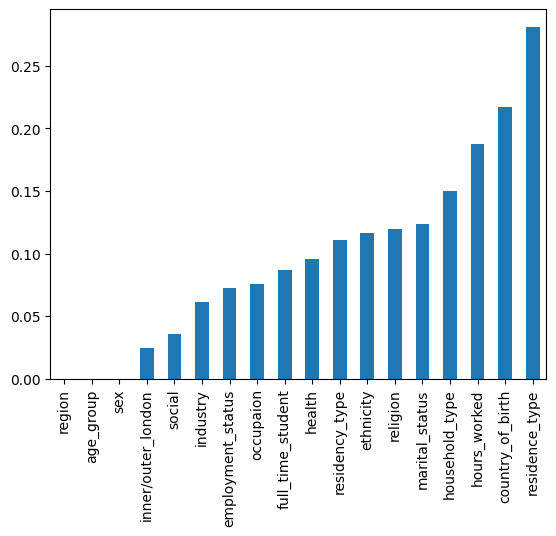

In [17]:
results = {}
for order in [1, 2]:
    print(f"Order {order}:")
    maes = {}
    cross_entropies = {}
    for name, index, x, xhat in iter_joint_probs(
        census, synthetic, order=order
    ):  
        cross_entropy = calc_cross_entropy(x, xhat)
        maes[name] = calc_mae(x, xhat)
    results[order] = maes

    mean_mae = sum(maes.values()) / len(maes)
    print(f"Mean MAE (order 1): {mean_mae:.4f}")

pd.Series(results[1]).sort_values().plot.bar()
plt.show()




In [18]:
results = {}
for order in range(1, 3):
    print(f"calculating order {order}")
    maes = {}
    for name, index, target, synthetic in compute_joint_frequencies(
        census, df, order=order
    ):
        join = join_probs(target, synthetic)
        maes[name] = calc_mnae(join)
    results[order] = maes

for order, res in results.items():
    print(f"Order {order}: MAE mean = {pd.Series(res).mean():.4f}")
    pd.Series(res).sort_values().plot.bar()
    plt.show()
    print(pd.Series(res).sort_values().tail(1))

calculating order 1


NameError: name 'compute_joint_frequencies' is not defined

In [ ]:
pd.Series(results[1]).sort_values().tail(1)

In [ ]:
census["household_type"].value_counts().join(
    df["household_type"].value_counts(), on="household_type", how="outer"
)

In [ ]:
df["household_type"].value_counts()